In [3]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps

def integrate(axis, start, end):
    """Integrates the given DoS data"""
    d_line = axis.get_lines()[1]
    x = d_line.get_xdata()[start:end]
    y = d_line.get_ydata()[start:end]
    pyplot.plot(x,y)
    return(simps(y,x))

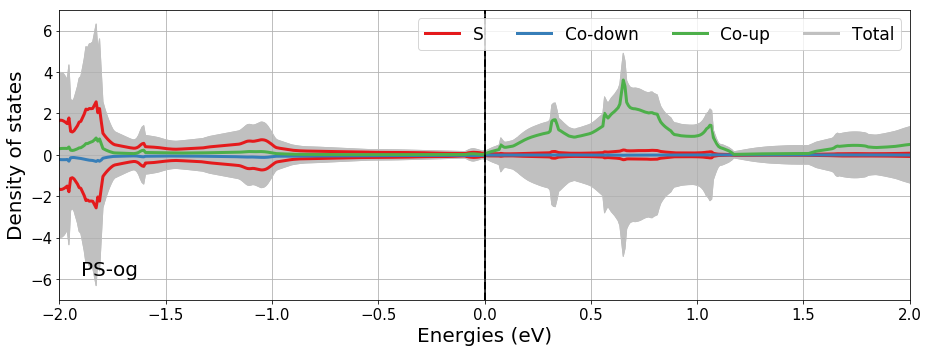

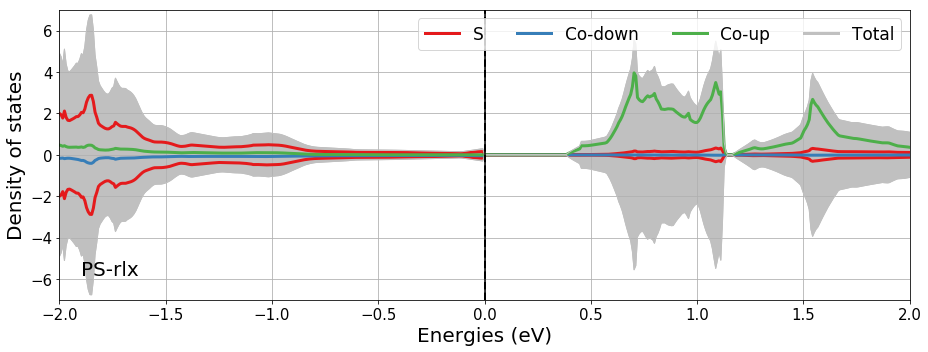

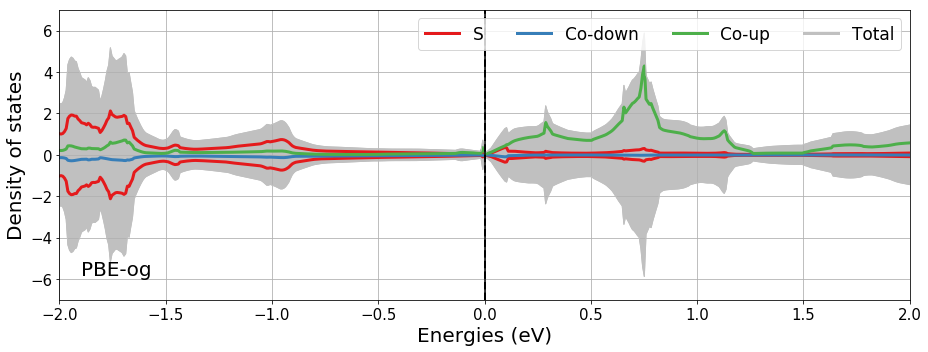

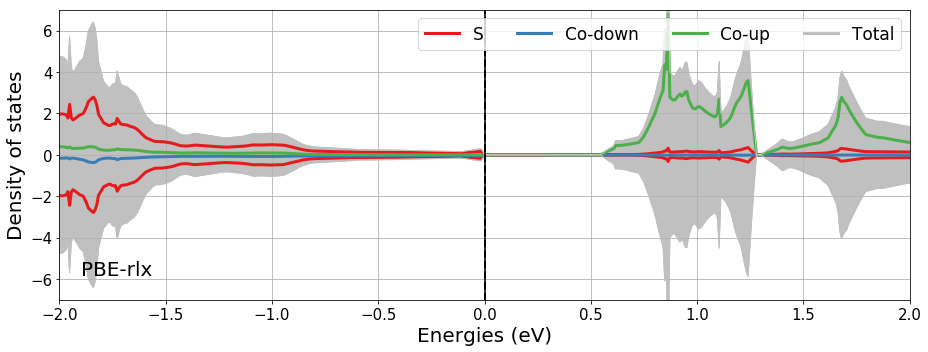

In [8]:
WIDTH = 13
HEIGHT = 5

DOS_TYPE = 'site-spin' #'element'
BY_ELEMENT = ["S"]
BY_SITE = [3]
ORBITALS_LS = [[4, 5, 6, 7, 8]] #desired orbitals corresponding to sites listed

PREFIX = "../../../PBESol-fixed-vol-U5/estruc/vasprun-dos"
SUFFIX = ".xml"
ITERS_1 = ["PS", "PBE"]
ITERS_2 = ['og', 'rlx']
LABELS_1 = ITERS_1
LABELS_2 = ITERS_2
LABEL_PREFIX = ""
XLIMS = [[-2,2]]*12
YLIMS = [[-7,7]]*12
LABEL_FONT = 20

axes = []

for i, iter_1 in enumerate(ITERS_1):
    for j, iter_2 in enumerate(ITERS_2):
        
        label = f'{iter_1}-{iter_2}'
        
            # Extract dos from vasprun
        vr = Vasprun(f'{PREFIX}-{label}{SUFFIX}')
        cdos = vr.complete_dos
        tdos = vr.tdos
        
        dplt = DosPlotter()

            # Add total dos
        dplt.add_dos("Total", tdos)
        
            # Add site doss
        pdoss = cdos.pdos
        for site_idx, orbitals in zip(BY_SITE, ORBITALS_LS):
            site = cdos.structure[site_idx]
            elem = site.species.elements[0]
            efermi = cdos.efermi
            energies = cdos.energies
            for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                
                dplt.add_dos(f'{elem}-{spin_label}', 
                             Dos(efermi, energies, {spin: sum(spin_doss)})
                
        #         if DOS_TYPE == 'site':
        #             for site_idx in SITES:
        #                 site = cdos.structure[site_idx]
        #                 elem = cdos.structure[2].species.elements[0]
        #                 dos = cdos.get_site_dos()
        #                 dplt.add_dos(elem, dos)

            # Add element dos
        elem_doss = cdos.get_element_dos()
        for element in BY_ELEMENT:
            dplt.add_dos(element, elem_doss[Element(element)])

            # Customize plot
        dos_plot = dplt.get_plot()
        dos_plot.xlim(XLIMS[i])
        dos_plot.ylim(YLIMS[i])
        dos_plot.axvline(x=0, color='k', linestyle='-')
        dos_plot.grid(1)

            # Make total line grey and filled in
        totLine = dos_plot.gca().get_lines()[3]
        totLine.set_color('silver')

        dos_plot.legend(loc='upper right', ncol=6, fontsize=LABEL_FONT-3) #keep line thick in legend

        totLine.set_linewidth(1)   

        totX = totLine.get_xdata()
        totY = totLine.get_ydata()

        dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
        dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')


            # Add a label to bottom right
        dos_plot.text(XLIMS[i][0]+0.1, YLIMS[i][0]+1.2, LABEL_PREFIX + label, fontsize=LABEL_FONT)

            # Chance font size
        dos_plot.gca().xaxis.label.set_fontsize(LABEL_FONT)
        dos_plot.gca().yaxis.label.set_fontsize(LABEL_FONT)
        pyplot.xticks(fontsize=LABEL_FONT-5)
        pyplot.yticks(fontsize=LABEL_FONT-5)

            # Add axes to persistent list
        axes.append(dos_plot.gca())


            # Resize/reshape
        fig = dos_plot.gcf()
        fig.set_size_inches(WIDTH,HEIGHT)

            # Show and save
        dos_plot.tight_layout()
        dos_plot.show()
        fig.savefig(f"elec_dos-{label}.png", img_format="png", dpi=300)
        fig.savefig(f"elec_dos-vec-{label}.pdf", img_format="pdf")



In [ ]:
start = 1150
end = 1220

print(f'd1 - {integrate(axes[-1], start, end)}')
print(f'd065 - {integrate(axes[5], 1250, 1350)}')


In [ ]:
6002-4900